env: XLA_PYTHON_CLIENT_MEM_FRACTION=.2
# of training images:12000
# of test images:2000


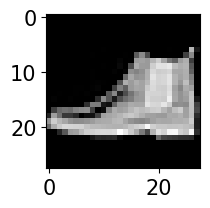

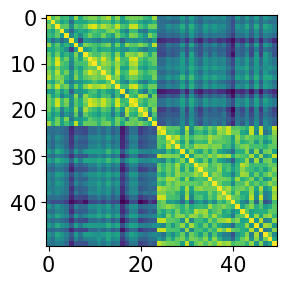

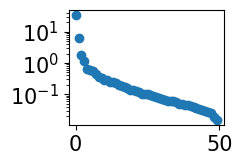

In [47]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.2

import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

import os
import sys

file = open("../../../../meta.txt")
home = file.read().replace("\n", "/")
file.close()
    
p = os.path.abspath(home+'mypylib')
if p not in sys.path:
    sys.path.append(p)

import chunGP as gp


seed=2
np.random.seed(seed)


N=50
P=10


labels=[6,9]#[6,9][5,8]
#labels=[8,9]#[7,9] #[0,1]
#angles=np.arange(N_total)
grayscale=False
All=False
#X,_,t_values,_,_,_,_,_,_,_=\
#    gp.getMNIST(N_train=N,N_test=100,normalize=True,seed=seed,labels=labels,All=All)
X,_,t_values,_,_,_,_,_,_,_=\
    gp.getFashion(N_train=N,N_test=100,normalize=True,seed=seed,labels=labels,All=All,home=home)
#X,_,t_values,_,_,_,_,_,_,_=\
#    gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,labels=labels,All=All,home=home)

#X=X-np.mean(X,axis=1)[:,None]
X=X/np.sqrt(np.sum(np.square(X),axis=1))[:,None]

Kxx=jnp.matmul(X,X.T)

fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.imshow(Kxx)

fig,ax=plt.subplots(1,1,figsize=(2,1.5))
_,s,_=jnp.linalg.svd(Kxx)
ax.scatter(np.arange(N),s)
ax.set_yscale('log')
    

In [48]:
import matplotlib as mpl

def updatec(cs,tau,m=0):
    sigop=np.squeeze(gp.getosig(tau))
    I_pih=gp.I2(jnp.array([jnp.pi/2]),jnp.array([tau]),n=10000)
    I_c=gp.I2(jnp.arccos(cs),jnp.array([tau]),n=10000)
    return jnp.squeeze(jnp.square(sigop)/(2*jnp.pi) * ( 2*I_c-tau*jnp.sqrt(2*jnp.pi)*(1+cs) + m*(2*I_pih-tau*jnp.sqrt(2*jnp.pi)) ))

pas=np.array([0.49999, 0.4, 0.3, 0.2, 0.1])
taus=gp.getTau(pas)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=pas.min(), vmax=pas.max())
# convert your distances to color coordinates
colors = cmap(norm(pas))


    

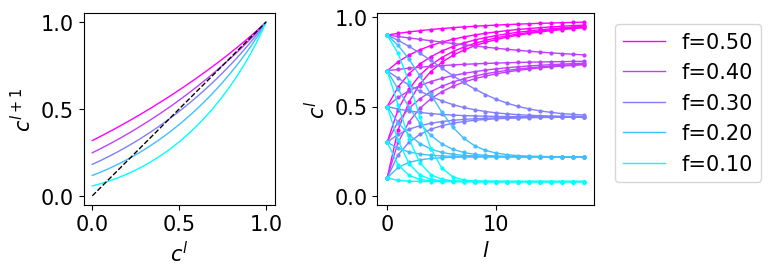

In [49]:
m=0

fig,ax=plt.subplots(1,2,figsize=(8,3))
for i,tau in enumerate(taus):
    I_0=gp.I2(jnp.array([0]),jnp.array([tau]),n=10000)
    I_pih=gp.I2(jnp.array([jnp.pi/2]),jnp.array([tau]),n=10000)

    sigop=jnp.sqrt( (2.0*jnp.pi) /( 2*I_0-2*tau*jnp.sqrt(2*jnp.pi) + m*(2*I_pih-tau*jnp.sqrt(2*jnp.pi)) ))
    sigop=sigop[0]

    cs=jnp.linspace(0,1,1000)
    cnext=updatec(cs,tau)
    
    ax[0].plot(cs,cnext,label='{:.0e}'.format(pas[i]),lw=1,c=colors[i])
ax[0].plot([0,1],[0,1],'k--',lw=1)
#ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#ax.legend()
ax[0].set_xlabel(r'$c^{l}$')
ax[0].set_ylabel(r'$c^{l+1}$')
ax[0].set_aspect('equal')

#fig,ax=plt.subplots(1,1,figsize=(3,3))
for j,tau in enumerate(taus):
    cs=jnp.linspace(0.1,0.9,5)
    css=[]
    css.append(cs)
    for i in range(18):
        cs=updatec(cs,tau)
        css.append(cs)
    css=np.array(css)

    ax[1].plot(css,'-o',c=colors[j],lw=1,markersize=2);
    ax[1].plot([0,0],[0,0],lw=1,c=colors[j],label='f={:.2f}'.format(pas[j]));
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[1].set_xlabel(r'$l$')
ax[1].set_ylabel(r'$c^l$')
plt.tight_layout()


0.49999
0.4
0.3
0.2
0.1


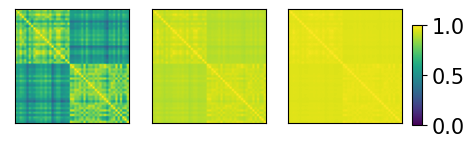

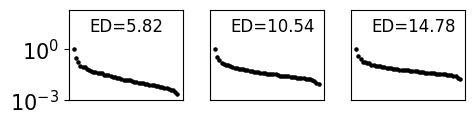

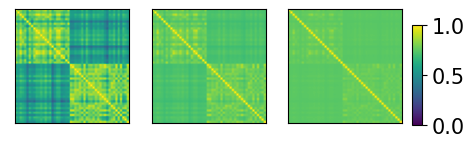

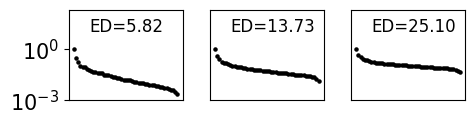

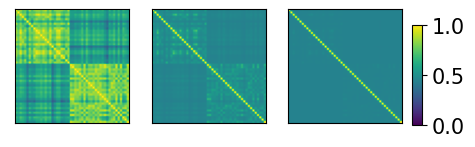

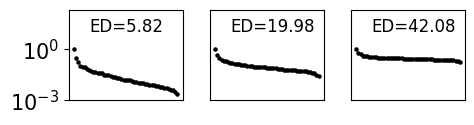

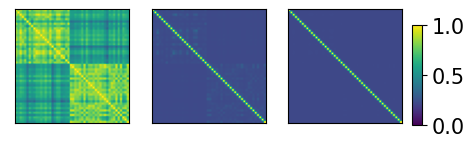

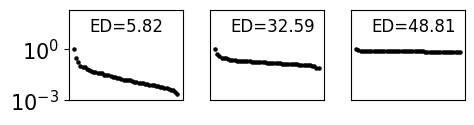

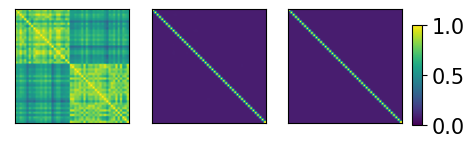

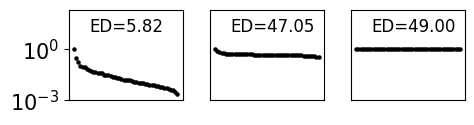

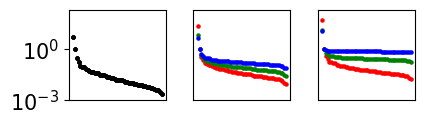

In [50]:
def getED(x): return np.square(np.sum(x))/np.sum(np.square(x))

np.random.seed(0)

vminv=1e-3
vmaxv=2*1e2

#N=5
#X=np.random.randn(N,N)
#X=X/(np.sqrt(np.sum(np.square(X),axis=1))[:,None])
K=np.matmul(X,X.T)
K=K/K[0,0]
#K[np.eye(N)==1]=1

Lid0=0
Lid1=5
Lid2=10

cmapp='viridis'
etas=[]
for j,tau in enumerate(taus):
    #cs=jnp.linspace(0.1,0.9,5)
    csf=K.flatten()
    Ks=[]
    Ks.append(csf.reshape((N,N)))
    etatemp=[]
    for i in range(18):
        csf=updatec(csf,tau)
        Kl=np.array(csf.reshape((N,N)))
        Kl[np.eye(N)==1]=1
        Ks.append(Kl)
    print(pas[j])
    fig,ax=plt.subplots(1,3,figsize=(5,2))
    im=ax[0].imshow(Ks[0],vmax=1,vmin=0,cmap=cmapp)
    ax[1].imshow(Ks[9],vmax=1,vmin=0,cmap=cmapp)
    ax[2].imshow(Ks[-1],vmax=1,vmin=0,cmap=cmapp)
    
    ax[0].get_xaxis().set_ticks([])
    ax[1].get_xaxis().set_ticks([])
    ax[2].get_xaxis().set_ticks([])
    ax[0].get_yaxis().set_ticks([])
    ax[1].get_yaxis().set_ticks([])
    ax[2].get_yaxis().set_ticks([])
    
    x1=0.92
    y1=0.2
    w1=0.02
    h1=0.5
    cax = fig.add_axes([x1,y1,w1,h1])
    plt.colorbar(im,cax=cax,aspect=10,shrink=0.5)#,orientation='horizontal')
    
    fig,ax=plt.subplots(1,3,figsize=(5,1.5))
    _,s,_=jnp.linalg.svd(Ks[Lid0])
    ax[0].scatter(np.arange(N)[1:],s[1:]/s[1],s=5,c='k')
    #ax[0].text(8,25,'ED={:.2f}'.format(getED(s)),fontsize=12)
    ax[0].text(8,10,'ED={:.2f}'.format(getED(s[1:])),fontsize=12)#,c='r')
    etatemp.append(s/s[1])
    _,s,_=jnp.linalg.svd(Ks[Lid1])
    ax[1].scatter(np.arange(N)[1:],s[1:]/s[1],s=5,c='k')
    #ax[1].text(8,25,'ED={:.2f}'.format(getED(s)),fontsize=12)
    ax[1].text(8,10,'ED={:.2f}'.format(getED(s[1:])),fontsize=12)#,c='r')
    etatemp.append(s/s[1])
    _,s,_=jnp.linalg.svd(Ks[Lid2])
    ax[2].scatter(np.arange(N)[1:],s[1:]/s[1],s=5,c='k')
    #ax[2].text(8,25,'ED={:.2f}'.format(getED(s)),fontsize=12)
    ax[2].text(8,10,'ED={:.2f}'.format(getED(s[1:])),fontsize=12)#,c='r')
    etatemp.append(s/s[1])
    ax[0].set_ylim([vminv,vmaxv])
    ax[1].set_ylim([vminv,vmaxv])
    ax[2].set_ylim([vminv,vmaxv])
    ax[0].get_xaxis().set_ticks([])
    ax[1].get_xaxis().set_ticks([])
    ax[2].get_xaxis().set_ticks([])
    
    
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')

    ax[1].get_yaxis().set_ticks([])
    ax[2].get_yaxis().set_ticks([])
    
    plt.tight_layout()
    
    etas.append(etatemp)
    
    
    
fig,ax=plt.subplots(1,3,figsize=(4.5,1.5))
ax[0].scatter(np.arange(N),etas[0][0],s=5,c='k')
ax[1].scatter(np.arange(N),etas[0][1],s=5,c='r')
ax[2].scatter(np.arange(N),etas[0][2],s=5,c='r')
ax[0].scatter(np.arange(N),etas[2][0],s=5,c='k')
ax[1].scatter(np.arange(N),etas[2][1],s=5,c='g')
ax[2].scatter(np.arange(N),etas[2][2],s=5,c='g')
ax[0].scatter(np.arange(N),etas[3][0],s=5,c='k')
ax[1].scatter(np.arange(N),etas[3][1],s=5,c='b')
ax[2].scatter(np.arange(N),etas[3][2],s=5,c='b')
ax[0].set_ylim([vminv,vmaxv])
ax[1].set_ylim([vminv,vmaxv])
ax[2].set_ylim([vminv,vmaxv])
ax[0].get_xaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
ax[2].get_xaxis().set_ticks([])


ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

ax[1].get_yaxis().set_ticks([])
ax[2].get_yaxis().set_ticks([])

plt.tight_layout()



In [94]:
def accuracy(y_pred,y):
    return jnp.mean(y_pred == y)
def getMax(yr_test):
    tp_test=jnp.argmax(yr_test,axis=1)
    return tp_test
np.random.seed(100)
Y=np.copy(t_values)
Y=Y-np.mean(np.unique(Y))
Y=(Y/np.max(Y))[:,None]
train_idx=np.random.choice(np.arange(N),P,replace=False)
train_ID=np.ones(N)==0
train_ID[train_idx]=True
test_ID=np.invert(train_ID)
x_train=X[train_ID,:]
x_test=X[test_ID,:]
y_train=Y[train_ID,:]
y_test=Y[test_ID,:]
    
    
resolution=100000000#100000000
trapz_n=10000
chunk_size=100000

Ls=jnp.arange(2,20)
#pas=[0.4999,0.2,0.1]
pas=jnp.linspace(0.4999,0.01,20)
taus=gp.getTau(jnp.array(pas))

etas=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N))
ED=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0]))
EDp=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0]))
errAf=np.copy(ED)
accAf=np.copy(ED)
zm=np.copy(etas)
phimean=np.copy(etas)
phistd=np.copy(etas)
for j, tau in enumerate(taus):
    sigma=np.squeeze(gp.getosig(tau))
    converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)
    load_names_te=gp.getSCK_fast_and_save(X,X,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')

    for g, L in enumerate(Ls):
        K=np.load(load_names_te[g])

        eta, Phi_d = jnp.linalg.eigh(K/N)
        inds = jnp.argsort(eta)[::-1]
        eta = jnp.abs(eta[inds] * (eta[inds] > 0))
        etas[j,g,:]=eta
        
        ED[j,g]=getED(eta)
        EDp[j,g]=getED(eta[1:])
            
        
        A=K[train_ID,:][:,train_ID]
        C=K[train_ID,:]                
        #yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
        yr_test=gp.train_single_fast(A,C,y_train,s0=0)
        errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))
        accAf[j,g]=accuracy(2*(yr_test>0)-1,Y)
        Phi_d=Phi_d[:,inds]
        zm[j,g,:]=Phi_d[:,0]*np.sqrt(N)
        phimean[j,g,:]=np.mean(Phi_d*np.sqrt(N),axis=0)
        phistd[j,g,:]=np.std(Phi_d*np.sqrt(N),axis=0)
        


loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel sav

9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done


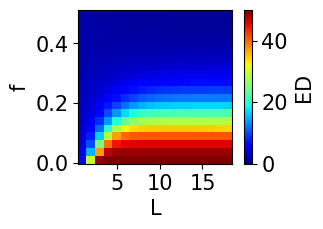

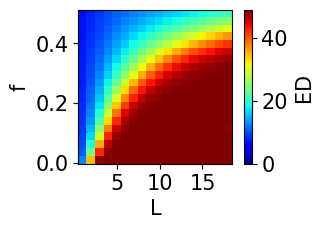

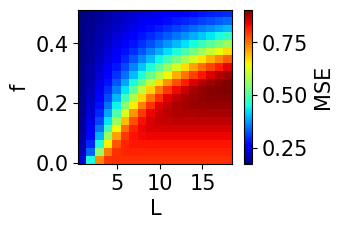

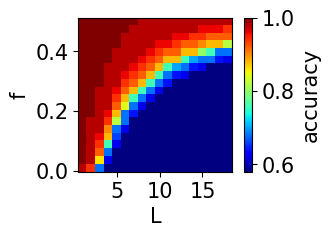

In [82]:
pas=jnp.linspace(0.4999,0.01,20)
taus=gp.getTau(jnp.array(pas))

fig,ax=plt.subplots(1,1,figsize=(3,2))
im=ax.pcolor(Ls-1,pas,ED,cmap='jet',vmax=N,vmin=0)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-5)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-3)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=0)#,vmax=0,vmin=-3)
cb=fig.colorbar(im, ax=ax)
cb.set_label('ED')
ax.set_xlabel('L')
ax.set_ylabel('f')
ax.set_box_aspect(1)

fig,ax=plt.subplots(1,1,figsize=(3,2))
im=ax.pcolor(Ls-1,pas,EDp,cmap='jet',vmax=N-1,vmin=0)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-5)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-3)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=0)#,vmax=0,vmin=-3)
cb=fig.colorbar(im, ax=ax)
cb.set_label('ED')
ax.set_xlabel('L')
ax.set_ylabel('f')
ax.set_box_aspect(1)

fig,ax=plt.subplots(1,1,figsize=(3,2))
im=ax.pcolor(Ls-1,pas,errAf,cmap='jet')#,vmax=N-1,vmin=0)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-5)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-3)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=0)#,vmax=0,vmin=-3)
cb=fig.colorbar(im, ax=ax)
cb.set_label('MSE')
ax.set_xlabel('L')
ax.set_ylabel('f')
ax.set_box_aspect(1)


fig,ax=plt.subplots(1,1,figsize=(3,2))
im=ax.pcolor(Ls-1,pas,accAf,cmap='jet')#,vmax=N-1,vmin=0)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-5)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-3)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=0)#,vmax=0,vmin=-3)
cb=fig.colorbar(im, ax=ax)
cb.set_label('accuracy')
ax.set_xlabel('L')
ax.set_ylabel('f')
ax.set_box_aspect(1)




Text(0, 0.5, 'std. of $\\phi_\\rho$')

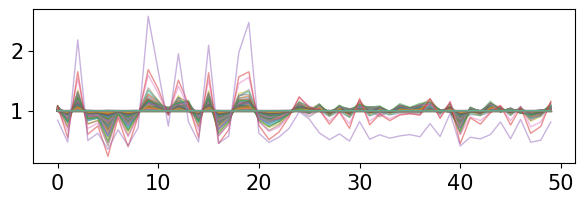

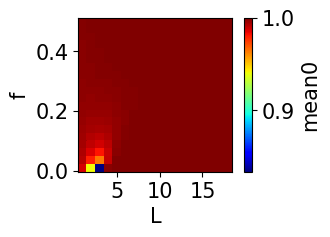

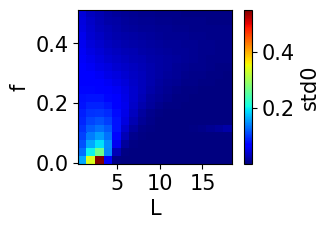

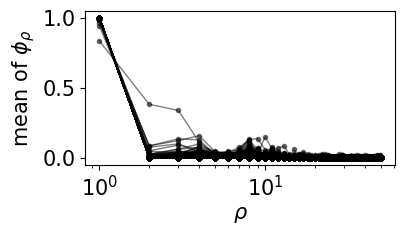

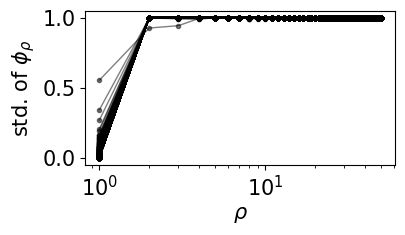

In [99]:
fig,ax=plt.subplots(1,1,figsize=(7,2))
for j, tau in enumerate(taus):
    for g, L in enumerate(Ls):
        ax.plot(np.abs(zm[j,g,:]),lw=1,alpha=0.5)

fig,ax=plt.subplots(1,1,figsize=(3,2))
im=ax.pcolor(Ls-1,pas,np.abs(np.mean(zm,axis=-1)),cmap='jet')#,vmax=N-1,vmin=0)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-5)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-3)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=0)#,vmax=0,vmin=-3)
cb=fig.colorbar(im, ax=ax)
cb.set_label('mean0')
ax.set_xlabel('L')
ax.set_ylabel('f')
ax.set_box_aspect(1)

fig,ax=plt.subplots(1,1,figsize=(3,2))
im=ax.pcolor(Ls-1,pas,np.abs(np.std(zm,axis=-1)),cmap='jet')#,vmax=N-1,vmin=0)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-5)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=-3)#,vmax=0,vmin=-3)
#im=ax.pcolor(Ls,pas,np.log10(EgSD),cmap='jet',vmax=5,vmin=0)#,vmax=0,vmin=-3)
cb=fig.colorbar(im, ax=ax)
cb.set_label('std0')
ax.set_xlabel('L')
ax.set_ylabel('f')
ax.set_box_aspect(1)

fig,ax=plt.subplots(1,1,figsize=(4,2))
ax.plot(np.arange(N)+1,np.abs(phimean.reshape((-1,N)).T),'k-o',lw=1,ms=3,alpha=0.5);
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'mean of $\phi_\rho$')

fig,ax=plt.subplots(1,1,figsize=(4,2))
ax.plot(np.arange(N)+1,np.abs(phistd.reshape((-1,N)).T),'k-o',lw=1,ms=3,alpha=0.5);
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\rho$')
ax.set_ylabel(r'std. of $\phi_\rho$')


In [23]:
accAf

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
    